# HW1 Notebook
#### This assignment will introduce you with the Intel DevCloud and with OpenMP basic directives and concepts of parallel computing as part of the OpenMP Common Core. 

#### Use this notebook to compile your files, submit your jobs to Intel DevCloud nodes and observe/analyze your results.
## Submittion instructions
- #### Publication Date: 10/11.
- #### Submission Date: 4/12.
- #### Submittion in groups of up to 2 students (individually or in pairs). 
- #### Submittion on the course website, in zip format including this directory with the relevant output, specifically: 
  - the source files.
  - this notebook (run_hw1.ipynb) after executing all the cells. 
  - output files of queued jobs that might be created during the execution. 

### Fill the name and ID of the submitters:
#### Student Name: Manor Zvi Stdudent ID: 204030720
**Note:** If you submit in pairs, it is sufficient that only single student submit the assaignment on the course website. \
Remove one line if submitted individually, or keep it empty.

## the Portable Batch System (PBS) on Intel DevCloud

Portable Batch System (PBS) is the scheduler that is used on Intel DevCloud to submit jobs on the cluster. \
The next material may help you manage your work on the cloud:
- **Quick tutorial for PBS:** https://albertsk.files.wordpress.com/2011/12/pbs.pdf.
- **Intel DevCloud Job Submission:** https://devcloud.intel.com/oneapi/documentation/job-submission.
- **Intel DevCloud Queue Management:** https://devcloud.intel.com/oneapi/documentation/advanced-queue.

## Problem 1: Know Your Hardware (10 points)
### In this section we will get familiar with Intel DevCloud nodes, and learn how to simply submit a job via the PBS scheduler. 
- The _pbsnodes_ command is used to find out the architectures and features of the compute nodes available to you. The actual output of pbsnodes may be very long if your share of the Intel® DevCloud includes a lot of compute nodes, so you may need to pipe the output. Specifically, it might be interesting to get the list of all the different properties and the number of nodes associated with the property by running the following command:

In [1]:
! pbsnodes | grep "properties =" | awk '{print $3}' | sort | uniq -c

     25 core,tgl,i9-11900kb,ram32gb,netgbe,gpu,gen11
     78 xeon,cfl,e-2176g,ram64gb,net1gbe,gpu,gen9
      4 xeon,clx,ram192gb,net1gbe,batch,extended,fpga,stratix10,fpga_runtime
      6 xeon,icx,gold6348,ramgb,netgbe,jupyter,batch
     28 xeon,icx,plat8358,ram256gb,net1gbe,batch
      8 xeon,icx,plat8380,ram2tb,net1gbe,batch
     12 xeon,skl,gold6128,ram192gb,net1gbe,fpga_runtime,fpga,arria10
     86 xeon,skl,gold6128,ram192gb,net1gbe,jupyter,batch
     35 xeon,skl,gold6128,ram192gb,net1gbe,jupyter,batch,fpga_compile
     12 xeon,skl,ram384gb,net1gbe,renderkit


- The next script is used to print basic hardware specifications of a compute node. Run the next cell to print the content of the script.

In [2]:
#print content of check_specifications.sh
%pycat check_specifications.sh

#!/bin/bash
/bin/echo "##" $(whoami) is checking specifications of a standard CPU Intel DevCloud node
echo "########################################### lscpu:"
lscpu
echo "########################################### cat /proc/cpuinfo:"
cat /proc/cpuinfo
echo "########################################### cat /proc/meminfo:"
cat /proc/meminfo
echo "########################################### numactl --hardware"
numactl --hardware
exit


- We now submit the script to the Intel Dev Cloud using the _qsub_ command of PBS. 
When not providing any other parameters, this command allocates the first available node on the cluster for this job. For the next sections of this assignment, we only work with CPU threads (we do not need any further properties like GPU), so for now any node will be fine. Run the following cell. The output will be created in the current directory. Watch it.

In [3]:
#Alloc a CPU compute node and see its specifications
! chmod 755 check_specifications.sh;
! qsub check_specifications.sh

2054914.v-qsvr-1.aidevcloud


In [4]:
! qsub run_getconf.sh

2054915.v-qsvr-1.aidevcloud


In [5]:
! cat check_specifications.sh.o* | grep -E "Model name|Socket\(s\)|Core\(s\)|NUMA node\(s\)|Thread\(s\) per core|L1d cache|L1i cache|L2 cache|L3 cache|processor|cache size"

Thread(s) per core:              2
Core(s) per socket:              6
Socket(s):                       2
NUMA node(s):                    2
Model name:                      Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz
L1d cache:                       384 KiB
L1i cache:                       384 KiB
L2 cache:                        12 MiB
L3 cache:                        38.5 MiB
processor	: 0
cache size	: 19712 KB
processor	: 1
cache size	: 19712 KB
processor	: 2
cache size	: 19712 KB
processor	: 3
cache size	: 19712 KB
processor	: 4
cache size	: 19712 KB
processor	: 5
cache size	: 19712 KB
processor	: 6
cache size	: 19712 KB
processor	: 7
cache size	: 19712 KB
processor	: 8
cache size	: 19712 KB
processor	: 9
cache size	: 19712 KB
processor	: 10
cache size	: 19712 KB
processor	: 11
cache size	: 19712 KB
processor	: 12
cache size	: 19712 KB
processor	: 13
cache size	: 19712 KB
processor	: 14
cache size	: 19712 KB
processor	: 15
cache size	: 19712 KB
processor	: 16
cache size	: 19712 KB
pro

##### Explain what do you learn from the specs. Focus on:
- How many CPU sockets there are in the node?
- How many physical cores for each CPU socket?
- How many Non-Uniform Memory Access (NUMA) nodes in the system? What does it mean? 
- What does it mean "Thread(s) per core"? (Hint: check in google for "_Hyper-Threading_").
- What are the cache sizes in the system? 

* This node has two sockets, which means two CPUs on the same board, as can be seen when using *lscpu*, and grepping for: "Socket(s)."
* EACH CPU has 6 physical cores (lscpu | grep -E "Core\(s\) per socket").
    * Each core has 2 logical HW threads (using HyperThreading), which brings us to 12 (logical) cores per CPU.
    * Logical core means that the core exposes itself to the OS as two CPUs and the OS does not know that 'beneath the hood' it is interleaving between two streams of instructions.
    * That brings us to 24 logical CPUs in the node: 2 sockets X 6 physical cores per socket X 2 logical cores (HW threads) per physical core.
* There are 2 NUMA nodes in the system. (*lscpu | grep -E "NUMA node\(s\)"*).
    * It means that the cores are split into two groups; each has its subspace of memory close to it.
    * Each group of cores can still access the other part of the memory space, but it will take longer than accessing its own part.
    * *numactl --hardware* gives us the relative time each node accesses its own part of memory compared to the other:<br>
        node distances:<br>
        node 0--1<br>
        ---0 10 21<br>
        ---1 21 10<br>
      In other words, it takes ~2.1x longer to access the other NUMA node memory than access itself.
    * I'm assuming here each socket is a NUMA node, but in general, it does not most to be like that.
* In the Xeon Skylake architecture, each core supports two parallel 'execution contexts,' or in its other name: HW threads. These two threads share the HW resources beneath, and the CPU is interleaving between them following some criteria. 
    * Using SMT (Simultaneous MultiThreading), both treads are being interleaved in a fine-grained fashion, based on each other stalling for request completions (waiting for memory read response on a cache miss, for example). 
    * This feature supposes to improve each core utilization because 'less than double the HW does two times work.'
    * This should not be confused with SW threads (OS threads)! SW threads require OS intervention, which takes a lot of time and forces some assumptions on the programming model. HW threads are indifferent to the kind of SW running. 
* Cache sizes:
    * Each core has 32[KB] of L1d and 32[KB] of L1i. This is why *lscpu* tells us that L1d=384[KB] and L1i=384[KB]. We have 12 cores with 32[KB], so: 32*12=384.
    * Each core has 1[MB] of unified (data & instructions) L2. Therefore *lscpu* tells us that L2=12[MB].
    * Each CPU (1 per socket) has 19.25[MB] of unified to all cores L3. Therefore *lscpu* tells us that L3=19.25*2=38.5[MB]
    * Note that *proc/cpuinfo* shows us only the L3 cache size, although the information is presented per logical processor (24 cores).<br> Each L3 is shared between 6 physical or 12 logical cores.
    * I verified this data by the Xeon Gold 6128 spec and by using *getconf -a*, which displays the information per core.
    * https://www.intel.com/content/dam/www/public/us/en/documents/product-briefs/xeon-scalable-platform-brief.pdf
    


### Note: The _q_ script
The script file _q_ is used to submit jobs easily via PSB on Intel DevCloud. We will use it from now on. \
When _q_ is used to submit jobs within a Jupityer notebook, then if allocation of resources is enabled within 60 seconds, output will be printed on the notebook itself; otherwise the job will be queded for execution, and the associated output file will be created later in the current directory. \
**Therefore, pay attention that all jobs are completed on notebook or successfully create associated output files before you submit your work.**

## Problem 2: Warming-up (10 points)
### What are the difference (if any) between the three code snippets? 

In [6]:
%%writefile omp_warming_up_a.c
#include <stdio.h>
#include <omp.h>

void print_thread_iter(int i, int thread_id, int n_threads) {
    printf("T %d/%d @ %d\n", thread_id, n_threads, i);
}

int main(int argc, char** argv){

    #pragma omp parallel
    {
        for(int i=0; i<100; i++) {
            int thread_id = omp_get_thread_num() + 1;
            int n_threads = omp_get_num_threads();
            print_thread_iter(i, thread_id, n_threads);
        }
    }
    
    return 0;
}


Overwriting omp_warming_up_a.c


In [7]:
! gcc -o omp_warming_up_a -fopenmp omp_warming_up_a.c

In [8]:
%%writefile omp_warming_up_a.run
cd $PBS_O_WORKDIR
./omp_warming_up_a
echo "Bye Bye"

Overwriting omp_warming_up_a.run


In [9]:
! ./q omp_warming_up_a.run

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:03 R jupyterhub     
2054914.v-qsvr-1           ...ifications.sh u177183                0 R batch          
2054915.v-qsvr-1           run_getconf.sh   u177183                0 R batch          
2054916.v-qsvr-1           ...ming_up_a.run u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (omp_warming_up_a.run.o2054916)



In [10]:
%%writefile omp_warming_up_b.c
#include <stdio.h>
#include <omp.h>

void print_thread_iter(int i, int thread_id, int n_threads) {
    printf("T %d/%d @ %d\n", thread_id, n_threads, i);
}

int main(int argc, char** argv){

    #pragma omp parallel
    {
        #pragma omp for
        for(int i=0; i<100; i++) {
            int thread_id = omp_get_thread_num() + 1;
            int n_threads = omp_get_num_threads();
            print_thread_iter(i, thread_id, n_threads);
        }
    }
    
    return 0;
}


Overwriting omp_warming_up_b.c


In [11]:
! gcc -o omp_warming_up_b -fopenmp omp_warming_up_b.c

In [12]:
%%writefile omp_warming_up_b.run
cd $PBS_O_WORKDIR
./omp_warming_up_b
echo "Bye Bye"

Overwriting omp_warming_up_b.run


In [13]:
! ./q omp_warming_up_b.run

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:05 R jupyterhub     
2054918.v-qsvr-1           ...ming_up_b.run u177183                0 Q batch          

Waiting for Output ██████████████████████████████

In [14]:
%%writefile omp_warming_up_c.c
#include <stdio.h>
#include <omp.h>

void print_thread_iter(int i, int thread_id, int n_threads) {
    printf("T %d/%d @ %d\n", thread_id, n_threads, i);
}

int main(int argc, char** argv){

    #pragma omp parallel for
    for(int i=0; i<100; i++) {
        int thread_id = omp_get_thread_num() + 1;
        int n_threads = omp_get_num_threads();
        print_thread_iter(i, thread_id, n_threads);
    }
    
    return 0;
}


Overwriting omp_warming_up_c.c


In [15]:
! gcc -o omp_warming_up_c -fopenmp omp_warming_up_c.c

In [16]:
%%writefile omp_warming_up_c.run
cd $PBS_O_WORKDIR
./omp_warming_up_c
echo "Bye Bye"

Overwriting omp_warming_up_c.run


In [17]:
! ./q omp_warming_up_c.run

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:05 R jupyterhub     
2054920.v-qsvr-1           ...ming_up_c.run u177183                0 Q batch          

Waiting for Output ████████████

In code snippet A, each thread execute the whole for loop (10k iterations of 'do something').<br>
In code snippet B, OpenMP splits the for loop work between the available threads, so each thread execute 10k/T iterations. Since we didn't set the number of threads, OpenMP uses the default number which is the number of (logical) cores in the system, 24 in our case.<br> 
In code snippet C, it does the same thing as B, but the code is cleaner.<br><br>
I turned these code snippets into real code (see sections below), compiled it and run to make sure (and also just for fun). the results confirm the claims above. 



## Problem 3: Mandelbrot area (40 points)
The mandelbrot set is the set of complex numbers _c_ for which the function _z^2+c_ does not diverge when iterated from z=0. 
The area of the Mandelbrot set is known to be around 1.506.
The serial program in _mandel_serial.c_ loops over a grid of points (5000x5000 points) in the complex plane which contains the Mandelbrot set, and tests each point to see whether it is inside or outside the set.
#### In this exercise you will implement various parallel versions of the Mandelbrot program with OpenMP on a CPU node.
#### Edit the following files to implement parallelization with CPU threads for the given serial code using OpenMP according to the following requirements:
- **_mandel_parallel_critical.c_** - implementation using critical sections for synchronization of a single variable.
- **_mandel_parallel_atomic.c_** - implementation using atomic operations for synchronization of a single variable.
- **_mandel_parallel_false_sharing.c_** - implementation with global array of variables, each thread updates its own variable, creating false sharing (then a single thread reduce the results). 
- **_mandel_parallel_padding.c_** - as before, implementation with global array of variables, now using padding to prevent false sharing. 
- **_mandel_parallel_reduction.c_** - implementation with the reduction clause on a parallel loop construct.

##### Hint: In class we saw similar implementations for the Monte Carlo Pi Calculation.
##### You are required to test the parallel implementations with a varying number of compute threads. Note that we already made within the files the infrastructure to loop over varying number of threads (to make it easy to you).
##### Pay attention you keep the timers wrapping the main loop of calculation in your parallel implementations.

#### Then run the following cells, and collect the results.
Note that the _.sh._ files include the compilation of the source file for each implementation. In this assaignment we use the _icx_ compiler.  

In [18]:
cd problem3

/home/u177183/HW1/HW1/problem3


### mandel_serial.c

In [19]:
%pycat mandel_serial.c

/*
**  PROGRAM: Mandelbrot area
**
**  PURPOSE: Program to compute the area of a  Mandelbrot set.
**           Correct answer should be around 1.510659.
**           WARNING: this program may contain errors
**
**  USAGE:   Program runs without input ... just run the executable
**            
**  HISTORY: Written:  (Mark Bull, August 2011).
**           Changed "comples" to "d_comples" to avoid collsion with 
**           math.h complex type (Tim Mattson, September 2011)
*/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

# define NPOINTS 5000
# define MAXITER 5000

void testpoint(void);

struct d_complex {
   double r;
   double i;
};

struct d_complex c;
int numoutside = 0;

int main() {
    
   int i, j;
   double area, error, eps = 1.0e-5;
   double start_time, run_time;
   start_time = omp_get_wtime();
    
   // Loop over grid of points in the complex plane which contains 
   // the Mandelbrot set, test each point to see whether it is 
   // inside or ou

In [20]:
! rm run_serial.sh.e*
! rm run_serial.sh.o*

In [21]:
! chmod 755 ../q; chmod 755 mandel_serial.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_serial.sh; else ./run_serial.sh; fi

chmod: cannot access 'mandel_serial.sh': No such file or directory
Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:07 R jupyterhub     
2054921.v-qsvr-1           run_serial.sh    u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_serial.sh.o2054921)



In [22]:
! cat run_serial.sh.o*

cat: 'run_serial.sh.o*': No such file or directory


### mandel_parallel_critical.c

In [23]:
%pycat mandel_parallel_critical.c

/*
**  PROGRAM: Mandelbrot area
**
**  PURPOSE: Program to compute the area of a  Mandelbrot set.
**           Correct answer should be around 1.510659.
**           WARNING: this program may contain errors
**
**  USAGE:   Program runs without input ... just run the executable
**            
**  HISTORY: Written:  (Mark Bull, August 2011).
**           Changed "comples" to "d_comples" to avoid collsion with 
**           math.h complex type (Tim Mattson, September 2011)
*/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

# define NPOINTS 5000
# define MAXITER 5000
#define NELEMS(x)  (sizeof(x) / sizeof((x)[0]))

void testpoint(void);

struct d_complex {
   double r;
   double i;
};

struct d_complex c;
int numoutside = 0;

int main() {
    
    int threads[6] = {1,2,4,8,16,24};  
    int i, j;
    double area, error, eps = 1.0e-5;
    double start_time, run_time;

    // Test varying number of threads: 1,2,4,8,16 and 24 threads
    for (int k=0; k< NELEMS(thr

In [24]:
! rm run_parallel_critical.sh.e*
! rm run_parallel_critical.sh.o*

In [25]:
! chmod 755 run_parallel_critical.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_critical.sh; else ./run_parallel_critical.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:11 R jupyterhub     
2054921.v-qsvr-1           run_serial.sh    u177183         00:00:01 R batch          
2054924.v-qsvr-1           ...l_critical.sh u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_parallel_critical.sh.o2054924)



In [26]:
! cat run_parallel_critical.sh.o*

cat: 'run_parallel_critical.sh.o*': No such file or directory


### mandel_parallel_atomic.c

In [27]:
%pycat mandel_parallel_atomic.c

/*
**  PROGRAM: Mandelbrot area
**
**  PURPOSE: Program to compute the area of a  Mandelbrot set.
**           Correct answer should be around 1.510659.
**           WARNING: this program may contain errors
**
**  USAGE:   Program runs without input ... just run the executable
**            
**  HISTORY: Written:  (Mark Bull, August 2011).
**           Changed "comples" to "d_comples" to avoid collsion with 
**           math.h complex type (Tim Mattson, September 2011)
*/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

# define NPOINTS 5000
# define MAXITER 5000
#define NELEMS(x)  (sizeof(x) / sizeof((x)[0]))

void testpoint(void);

struct d_complex {
   double r;
   double i;
};

struct d_complex c;
int numoutside = 0;

int main() {
    
    int threads[6] = {1,2,4,8,16,24};  
    int i, j;
    double area, error, eps = 1.0e-5;
    double start_time, run_time;

    // Test varying number of threads: 1,2,4,8,16 and 24 threads
    for (int k=0; k< NELEMS(thr

In [28]:
! rm run_parallel_atomic.sh.e*
! rm run_parallel_atomic.sh.o*

In [29]:
! chmod 755 run_parallel_atomic.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_atomic.sh; else ./run_parallel_atomic.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:12 R jupyterhub     
2054921.v-qsvr-1           run_serial.sh    u177183         00:01:26 R batch          
2054924.v-qsvr-1           ...l_critical.sh u177183         00:00:10 R batch          
2054925.v-qsvr-1           ...lel_atomic.sh u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_parallel_atomic.sh.o2054925)



In [30]:
! cat run_parallel_atomic.sh.o*

cat: 'run_parallel_atomic.sh.o*': No such file or directory


### mandel_parallel_false_sharing.c

In [31]:
%pycat mandel_parallel_false_sharing.c

/*
**  PROGRAM: Mandelbrot area
**
**  PURPOSE: Program to compute the area of a  Mandelbrot set.
**           Correct answer should be around 1.510659.
**           WARNING: this program may contain errors
**
**  USAGE:   Program runs without input ... just run the executable
**            
**  HISTORY: Written:  (Mark Bull, August 2011).
**           Changed "comples" to "d_comples" to avoid collsion with 
**           math.h complex type (Tim Mattson, September 2011)
*/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

# define NPOINTS 5000
# define MAXITER 5000
#define NELEMS(x)  (sizeof(x) / sizeof((x)[0]))

void testpoint(int);

struct d_complex {
   double r;
   double i;
};

struct d_complex c;
//int threads[6] = {1,2,4,8,16,24};
int numoutside = 0;
int numoutside_per_thread[24] = {0};

int main() {
    
   int threads[6] = {1,2,4,8,16,24};  
   int i, j;
   double area, error, eps = 1.0e-5;
   double start_time, run_time;

   // Test varying number of

In [32]:
! rm run_parallel_false_sharing.sh.e*
! rm run_parallel_false_sharing.sh.o*

In [33]:
! chmod 755 run_parallel_false_sharing.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_false_sharing.sh; else ./run_parallel_false_sharing.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:15 R jupyterhub     
2054921.v-qsvr-1           run_serial.sh    u177183         00:02:11 R batch          
2054924.v-qsvr-1           ...l_critical.sh u177183         00:01:41 R batch          
2054925.v-qsvr-1           ...lel_atomic.sh u177183                0 R batch          
2054927.v-qsvr-1           ...se_sharing.sh u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_parallel_false_sharing.sh.

In [34]:
! cat run_parallel_false_sharing.sh.o*

cat: 'run_parallel_false_sharing.sh.o*': No such file or directory


### mandel_parallel_padding.c

In [59]:
%pycat mandel_parallel_padding_08pad.c

/*
**  PROGRAM: Mandelbrot area
**
**  PURPOSE: Program to compute the area of a  Mandelbrot set.
**           Correct answer should be around 1.510659.
**           WARNING: this program may contain errors
**
**  USAGE:   Program runs without input ... just run the executable
**            
**  HISTORY: Written:  (Mark Bull, August 2011).
**           Changed "comples" to "d_comples" to avoid collsion with 
**           math.h complex type (Tim Mattson, September 2011)
*/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

# define NPOINTS 5000
# define MAXITER 5000
#define NELEMS(x)  (sizeof(x) / sizeof((x)[0]))
# define PAD 8

void testpoint(int);

struct d_complex {
   double r;
   double i;
};

struct d_complex c;
int numoutside = 0;
int numoutside_per_thread[24][PAD] = {0};

int main() {
    
   printf("sizeof(numoutside_per_thread[0][0]) = %lu\n", sizeof(numoutside_per_thread[0][0]));
    
   int threads[6] = {1,2,4,8,16,24};  
   int i, j;
   double area

In [60]:
! rm run_parallel_padding_08pad.sh.e*
! rm run_parallel_padding_08pad.sh.o*

In [61]:
! chmod 755 run_parallel_padding_08pad.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_padding_08pad.sh; else ./run_parallel_padding_08pad.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:28 R jupyterhub     
2054952.v-qsvr-1           ...ding_08pad.sh u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_parallel_padding_08pad.sh.o2054952)



In [62]:
! cat run_parallel_padding_08pad.sh.o*

cat: 'run_parallel_padding_08pad.sh.o*': No such file or directory


In [63]:
! rm run_parallel_padding_16pad.sh.e*
! rm run_parallel_padding_16pad.sh.o*

In [64]:
! chmod 755 run_parallel_padding_16pad.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_padding_16pad.sh; else ./run_parallel_padding_16pad.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:31 R jupyterhub     
2054952.v-qsvr-1           ...ding_08pad.sh u177183         00:00:12 R batch          
2054953.v-qsvr-1           ...ding_16pad.sh u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_parallel_padding_16pad.sh.o2054953)



In [65]:
! cat run_parallel_padding_16pad.sh.o*

cat: 'run_parallel_padding_16pad.sh.o*': No such file or directory


### mandel_parallel_reduction.c

In [42]:
%pycat mandel_parallel_reduction.c

/*
**  PROGRAM: Mandelbrot area
**
**  PURPOSE: Program to compute the area of a  Mandelbrot set.
**           Correct answer should be around 1.510659.
**           WARNING: this program may contain errors
**
**  USAGE:   Program runs without input ... just run the executable
**            
**  HISTORY: Written:  (Mark Bull, August 2011).
**           Changed "comples" to "d_comples" to avoid collsion with 
**           math.h complex type (Tim Mattson, September 2011)
*/

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>

# define NPOINTS 5000
# define MAXITER 5000
#define NELEMS(x)  (sizeof(x) / sizeof((x)[0]))

void testpoint(void);

struct d_complex {
   double r;
   double i;
};

struct d_complex c;
int numoutside = 0;

int main() {
    
   int threads[6] = {1,2,4,8,16,24};  
   int i, j;
   double area, error, eps = 1.0e-5;
   double start_time, run_time;

   // Test varying number of threads: 1,2,4,8,16 and 24 threads
   for (int k=0; k< NELEMS(threads);

In [43]:
! rm run_parallel_reduction.sh.e*
! rm run_parallel_reduction.sh.o*

In [44]:
! chmod 755 run_parallel_reduction.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_reduction.sh; else ./run_parallel_reduction.sh; fi

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
2054745.v-qsvr-1           ...ub-singleuser u177183         00:01:18 R jupyterhub     
2054924.v-qsvr-1           ...l_critical.sh u177183         00:03:28 R batch          
2054925.v-qsvr-1           ...lel_atomic.sh u177183         00:02:10 R batch          
2054927.v-qsvr-1           ...se_sharing.sh u177183         00:01:21 R batch          
2054931.v-qsvr-1           ..._reduction.sh u177183                0 Q batch          

Waiting for Output ████████████████████████████████████████████████████████████

TimeOut 60 seconds: Job is still queued for execution, check for output file later (run_parallel_reduction.sh.o205

In [45]:
! cat run_parallel_reduction.sh.o*

cat: 'run_parallel_reduction.sh.o*': No such file or directory


In [69]:
import os
import re
import sys
from pprint import pprint
import pandas as pd

df = pd.DataFrame({'#Threads': [1,2,4,8,16,24], 'serial': [None]*6, 'critical': [None]*6, 'atomic': [None]*6, 'false sharing': [None]*6, 'padding(PAD=08)': [None]*6, 'padding(PAD=16)': [None]*6, 'reduction': [None]*6,})
df = df.set_index('#Threads')

o_files = os.listdir(os.getcwd())
r = re.compile("^.*.sh.o\d+$")
o_files = list(filter(r.match, o_files))
for o_file in o_files:
    print(f'Reading {o_file} ... ')
    file = open(o_file, 'r')
    for line in file:
        if re.match('^run_serial.*$', o_file):
            name = 'serial'
            r_time = re.findall('.*time: (\d+).(\d+) seconds.*', line)
            threads_num = 1
            if r_time:
                time = float(f'{r_time[0][0]}.{r_time[0][1]}')
            df[name][threads_num] = time
        else:
            r_name = re.findall('.*Calculate Mandelbrot area - parallel (.*).*', line)
            if r_name:
                name = r_name[0].replace('_', ' ')
            r_threads_num = re.findall('.*time: (\d+).(\d+) seconds, with (\d+) threads.*', line)
            if r_threads_num:
                time = float(f'{r_threads_num[0][0]}.{r_threads_num[0][1]}')
                threads_num = int(r_threads_num[0][2])
                df[name][threads_num] = time
df

Reading run_parallel_false_sharing.sh.o2054927 ... 
Reading run_serial.sh.o2054921 ... 
Reading run_parallel_reduction.sh.o2054931 ... 
Reading run_parallel_padding_08pad.sh.o2054952 ... 
Reading run_parallel_atomic.sh.o2054925 ... 
Reading run_parallel_padding_16pad.sh.o2054953 ... 
Reading run_parallel_critical.sh.o2054924 ... 


,serial,critical,atomic,false sharing,padding(PAD=08),padding(PAD=16),reduction
#Threads,,,,,,,
1,210.41885,122.229067,210.497242,210.471747,210.5154,210.438692,210.470642
2,None,104.197882,67.060966,93.528301,76.16452,107.818921,112.283267
4,None,55.801332,29.961975,24.054908,44.686276,42.451612,42.560882
8,None,34.483548,15.937765,18.023755,18.963222,24.089648,26.996938
16,None,19.602682,14.518127,7.610936,13.733502,9.590189,16.2149
24,None,15.083375,7.55655,5.552312,6.8492,7.785516,9.505689


### Summering the results
#### Fill the following table with the execution times (in seconds) according to the number of threads:

In [71]:
df

,serial,critical,atomic,false sharing,padding(PAD=08),padding(PAD=16),reduction
#Threads,,,,,,,
1,210.41885,122.229067,210.497242,210.471747,210.5154,210.438692,210.470642
2,None,104.197882,67.060966,93.528301,76.16452,107.818921,112.283267
4,None,55.801332,29.961975,24.054908,44.686276,42.451612,42.560882
8,None,34.483548,15.937765,18.023755,18.963222,24.089648,26.996938
16,None,19.602682,14.518127,7.610936,13.733502,9.590189,16.2149
24,None,15.083375,7.55655,5.552312,6.8492,7.785516,9.505689


### Fill the results in the following pyplot figure to create a stong scale graph:
Note that the values on the graph should be the speedup achieved (relative to a serial computation).

In [72]:
serial_exec_time = df['serial'][1]
critical_exec_time = df['critical']
atomic_exec_time = df['atomic']
false_sharing_exec_time = df['false sharing']
padding08_exec_time = df['padding(PAD=08)']
padding16_exec_time = df['padding(PAD=16)']
reduction_exec_time = df['reduction']

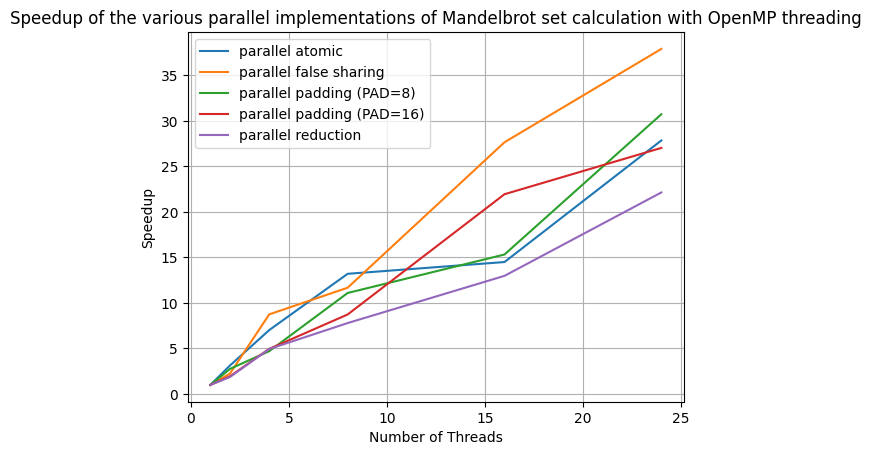

In [73]:
import matplotlib.pyplot as plt
threads = [1,2,4,8,16,24]
speedup_critical      = [serial_exec_time / x for x in critical_exec_time]
speedup_atomic        = [serial_exec_time / x for x in atomic_exec_time]
speedup_false_sharing = [serial_exec_time / x for x in false_sharing_exec_time]
speedup_padding08       = [serial_exec_time / x for x in padding08_exec_time]
speedup_padding16       = [serial_exec_time / x for x in padding16_exec_time]
speedup_reduction     = [serial_exec_time / x for x in reduction_exec_time]

# plt.plot(threads, speedup_critical, label = "parallel critical")
plt.plot(threads, speedup_atomic, label = "parallel atomic")
plt.plot(threads, speedup_false_sharing, label = "parallel false sharing")
plt.plot(threads, speedup_padding08, label = "parallel padding (PAD=8)")
plt.plot(threads, speedup_padding16, label = "parallel padding (PAD=16)")
plt.plot(threads, speedup_reduction, label = "parallel reduction")
  
# naming the x axis
plt.xlabel('Number of Threads')
# naming the y axis
plt.ylabel('Speedup')
# giving a title to my graph
plt.title('Speedup of the various parallel implementations of Mandelbrot set calculation with OpenMP threading')
plt.grid()
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

### Explain the results
Try to explain the results, by comparing the results of different implementations.

* Put aside the critical results - they make no sense, I will wait for Yehonatan answer. 
* For the rest of the implementations, we see sub-linear speedup, almost equal for all of them.
* On the one hand, it makes sense, since the synchronization event is quite rare: assume at a given time all available threads are working on different complex numbers. each thread performs ~5000 iteration between trying to access the *numoutside variable, perhaps even more, because for numbers inside the Mandelbrot set, the if statments inside *testpoint is never satisfied.
* On the other hand, I expected some bigger diffrences between the false sharing & the padding, for example.
    * I also checked, and each L1 cache line in Xeon 6128 Gold is 64 Bytes. Current compiler interprets *int as 4[B] word, so we have 16 words per eac cache line, not 8.<br>
    * To check this hypothesis, I created 2 versions of *mandel_parallel_padding.c: *_08pad & *_16pad.
    * Also here, the results are almost equal. 
* I think that the similar results for all implementations stems from some low-level optimizations the compiler does, which I'm not aware of. 

## Problem 4: nowait clause (10 points)
**The nowait clause is used to avoid the implied barrier at the end of a loop construct, when you have multiple independent loops within a parallel region.** \
For each following code snippet, we added OpenMP parallelization using the nowait clause to a given code section. 
We assume that a,b,y and z point to different pre-allocated arrays (each of size n). \
**For each code snippet, decide whether the parallel code is correct (always brings to the same result as in a serial execution), and explain your decision.**

In [ ]:
#include <math.h>
void nowait_example_1(int n, float *a, float *b, float *y, float *z)
{
    int i;
    #pragma omp parallel
    {
        #pragma omp for nowait
        for (i=0; i<n-1; i++)
            b[i] = (a[i] + a[i+1]) / 2.0;
            
        #pragma omp for nowait
        for (i=0; i<n; i++)
            y[i] = sqrt(z[i]);  
    }
}


In [ ]:
#include <math.h>
void nowait_example_2(int n, float *a, float *b, float *y, float *z)
{
    int i;
    #pragma omp parallel
    {
        #pragma omp for schedule(static) nowait
        for (i=0; i<n; i++)
            b[i] = a[i] / 2.0;
            
        #pragma omp for schedule(static) nowait
        for (i=0; i<n; i++)
            y[i] = sqrt(b[i]);  
    }
}

* This snippt is wrong because the 2nd loop uses the 1st loop results. Therefore, some threads might finish their work on the 1st loop, continue to the 2nd loop and read wrong values of b.<br>
* the schedule(static) clause makes the worksharing to happen at compile time (a.k.a 'static'), that means, deal-out blocks of iterations of size “chunk” to each thread.<br>
* However, there is no guarentees on which 'chunk' each thread gets. for example, thread t might get iteration [0-n/T-1] of the 1st for loop, but then iterations [n/T-2*n/T-1] of the 2nd for loop.<br>
In such case, he might read outdated values of b, which is wrong. 

In [ ]:
#include <math.h>
void nowait_example_2(int n, float *a, float *b, float *y, float *z)
{
    int i;
    #pragma omp parallel
    {
        #pragma omp for schedule(dynamic, 8) nowait
        for (i=0; i<n; i++)
            b[i] = a[i] / 2.0;
            
        #pragma omp for schedule(dynamic,8) nowait
        for (i=0; i<n; i++)
            y[i] = sqrt(b[i]);  
    }
}

Simiar to the previous snippt, I think this one is wrong too.<br>
In contrast to schedule(static), here schedule(dynamic, <chunk>) deals out <chunk> of iterations per thread, and when the thread finishes his current chunk, he comes back to the schedule and claims another chunk of iterations.<br>
Similar to the static case, I think this one is wrong for the same reason: there is no guarentees on the policy of worksharing for the 2nd for loop.<br>
It might be the same policy and then each thread will get the same iterations indices in both loops, but it might be different. 

In [ ]:
#include <math.h>
void nowait_example_4(int n, float *a, float *b, float *y, float *z)
{
    int i;
    #pragma omp parallel
    {
        #pragma omp single nowait
        for (i=0; i<n; i++)
            b[i] = a[i] / 2.0;        
            
        #pragma omp single nowait
        for (i=0; i<n; i++)
            y[i] = sqrt(b[i]);  
    }
}

This snippet is ok, although highly non efficient...<br>
the single construct make the 1st loop to be executed by a single thread only. Therfore, the 1st nowait has no practical meaning, anyway the single thread have to finish all iterations before it can continue to the 2nd loop.

In [ ]:
#include <math.h>
void nowait_example_5(int n, float *a, float *b, float *y, float *z)
{
    int i;
    #pragma omp parallel
    {
        #pragma omp master nowait
        for (i=0; i<n; i++)
            b[i] = a[i] / 2.0;        
            
        #pragma omp master nowait
        for (i=0; i<n; i++)
            y[i] = sqrt(b[i]);  
    }
}

Similar to the previous snippet, this one is ok. The master construct makes both loops to be executed by the master thread, which is basically equivalent to regular serial code without OpenMP.

## Problem 5: Count Prime Numbers (30 points)
**The schedule clause is used to provide more control over how iterations of a worksharing-loop construct are scheduled onto the threads, usually to balance the workload across threads. It supports both static and dynamic scheduling.**

In [ ]:
cd ../problem5

The following serial code counts the amount of prime numbers up to a given limit, by checking for each integer whther it is prime or not.

In [ ]:
%pycat prime_parallel_schedule.c

In this problem you are required to add parallelization to the main loop of the problem, **using the reduction and schedule clauses**. \
The main focus in your solution will be on choosing the best schedule method (default, static, dynamic, etc) along with the optimized chunk size for a given CPU node on Intel DevCloud. 
#### Fill the following table with run times (in seconds) for each schedule you examine and for different numbers of threads. Then report what is the optimal schedule method you found and explain your observation. Fill free to add/edit lines in order to tune the parameters, finding the best option you can.

|  schedule           |      1 threads    |      2 threads    |      4 threads      |      8 threads      |      16 threads     |      24 threads     |
|:-------------------:|:-----------------:|:-----------------:|:-------------------:|:-------------------:|:-------------------:|:-------------------:|
| default             |      55.186320    |       34.554892   |        18.537169    |        9.631764     |        5.441234     |        4.541834     |
| static              |      55.054896    |       34.581313   |        18.555245    |        9.634384     |        6.031447     |        4.554096     |
| static,4            |      55.090993    |       27.620516   |        13.826532    |        6.997109     |        4.848742     |        4.562501     |
| dynamic,8           |      55.086151    |       27.652851   |        13.866090    |        6.967400     |        4.249884     |        4.115957     |
| guided              |      55.098750    |       27.559325   |        13.790044    |        7.032963     |        4.236675     |        3.607506     |
| static,8            |      55.139579    |       27.607329   |        13.830751    |        7.175682     |        4.835663     |        3.605453     |
| guided,8            |      55.119804    |       27.557552   |        13.810870    |        6.970867     |        4.251963     |        3.606522     |

Use _prime_parallel.c_ to edit your parallel implementation. The next cell will help you to execute every time you examine a new schedule option. When you finish, keep the file _prime_parallel.c_ with the optimal schedule you found and execute again. 

In [ ]:
%pycat prime_parallel_schedule.c

In [ ]:
! chmod 755 ../q; chmod 755 run_parallel_schedule.sh;if [ -x "$(command -v qsub)" ]; then ./../q run_parallel_schedule.sh; else ./run_parallel_schedule.sh; fi

* The optimal scheduling method I've found is the **guided** scheduling (with the static with chunk size 8 is roughly equal) at 24 threads. 
* It somehow makes sense, because in guided scheduling we start with large chunk size and slowly decrease it based on the runtime of previous iterations. 
* It fits this algorithm because for each integer under examination, the inner loop get bigger & bigger (O(sqrt(num))), and therfore to maintain load balancing between the threads as the computation is advancing, the scheduler decrease the chunk size.
* I don't have a good explanation how the static scheduler achieves equivalent results at 24 threads.
* A few words about searching the search space:
    * I noticed that static, 4 is better than static. So I checked if there is a trend here - tried static, 8 - but it is not better than the guided. 
    * If guided was the best for low thread count, and static, 8 is equivalent for high thread count, I tried to combine them in guided, 8. But the results are no better than guided.
    * There is no point to check nore than 24 thread, since we have 24 logical cores in the system. If the application was memory-limited or I/O-limited, there might be a good point to use more threads than cores, because the OS could interleaved between multiple threads each time one thread is stuck on memory or I/O access.<br>
    But this is not the case here: this is highly compute-bounded application.

### Intel VTune
**Now you will get experienced with Intel VTune, to analyze the load balancing of your prime numbers program.** \
According to the table above, find one good scheduling method and one bad scheduling method. Use VTune to show the good/bad load balancing between all the threads for both executions respectively. \
Upload a printscreen of the threading information from VTune. Upload both images in the current directory (problem5) with the following names respectively: \
_vtune_good_load_balancing.png_ \
_vtune_bad_load_balancing.png_ \
You can use the _upload_ button in JupyterLab to easily upload the images. 
Then run both cells to show the images on the notebook.


In [ ]:
from IPython.display import Image
Image(filename='vtune_good_load_balancing.png') 

In [ ]:
Image(filename='vtune_bad_load_balancing.png') 